In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cellfate import model, io, celldensity
import emcee
import scipy.optimize as op
import imp

# With diffusion

## 10 x 10 bins

In [31]:
imp.reload(model)

<module 'cellfate.model' from '/Users/lsh/Desktop/2016-17/PHYS 201/cellfate/cellfate/model.py'>

In [34]:
testobject = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 12)

In [35]:
testobject.length_scale

1.33

In [44]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1, 0.1])

def residual(theta, data, mu_n, sigma_n):
    m = model.solver_coupled(theta, data)[:,1:-1,1:-1,:]
    y = data.pd2np()[:,1:-1,1:-1,:]
    
    nonzero_args = np.nonzero(y)
    y = y[nonzero_args]
    m = m[nonzero_args]
            
    return (np.log(y) - np.log(m) - mu_n)/sigma_n
    
res = op.leastsq(residual, x0, args=(testobject, -0.15, 0.1))

res[0]

array([ 0.02115077,  0.00279293,  0.00013236,  0.00061019])

CPU times: user 11.3 s, sys: 1.47 s, total: 12.8 s
Wall time: 32min 51s
Done


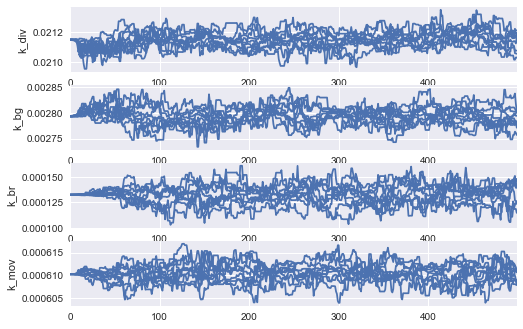

In [45]:
# We have 3 parameters. 
# We use 20 walkers and 500 steps, which turns out to be a sufficient number.
ndim = 4
nwalkers = 20
nsteps = 500
init_params = res[0]
spread = 10**(np.floor(np.log10(res[0]))-4)

# Starting positions in Gaussian ball
starting_positions = [init_params + spread*np.random.randn(ndim) for i in range(nwalkers)]

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_posterior_coupled, 
                                args=(testobject, -0.15, 0.1), threads=4)

# Run the sampler.
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

# Let's plot 10 walkers from the samler chain to observe convergence.
fig, (ax_k_div, ax_k_bg, ax_k_br, ax_k_mov) = plt.subplots(4)
ax_k_div.set(ylabel='k_div')
ax_k_bg.set(ylabel='k_bg')
ax_k_br.set(ylabel='k_br')
ax_k_mov.set(ylabel='k_mov')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_k_bg)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_k_br)
    sns.tsplot(sampler.chain[i,:,3], ax=ax_k_mov)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


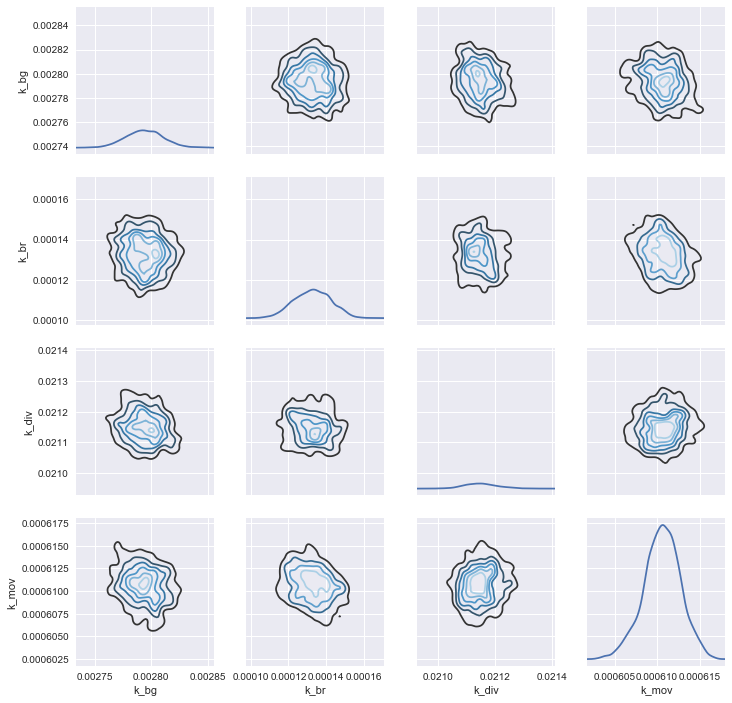

In [46]:
# Since V_b converges around 300, let's set burnin time as 300 steps.
samples = sampler.chain[:,300:,:]

# reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
traces = samples.reshape(-1, ndim).T

# Create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_bg': traces[1], 'k_br': traces[2], 'k_mov': traces[3]})

# Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
g = sns.PairGrid(parameter_samples)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);

In [47]:
k = [parameter_samples['k_div'].median(), parameter_samples['k_bg'].median(), parameter_samples['k_br'].median(),
    parameter_samples['k_mov'].median()]

print('k_div = %.5f' % (parameter_samples['k_div'].median()))
print('k_bg = %.5f' % (parameter_samples['k_bg'].median()))
print('k_br = %.10f' % (parameter_samples['k_br'].median()))
print('k_mov = %.7f' % (parameter_samples['k_mov'].median()))

k_div = 0.02115
k_bg = 0.00279
k_br = 0.0001329480
k_mov = 0.0006106


In [26]:
testobject2 = io.read('expt128-redoSoxNuclei.csv', 'Sox2', 'Oct4', 12)

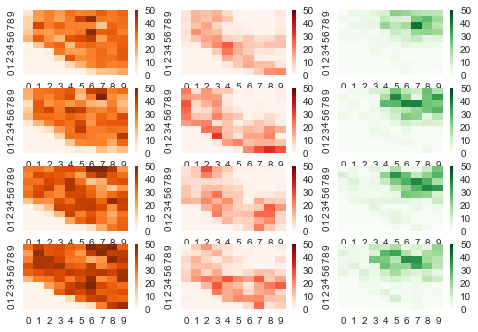

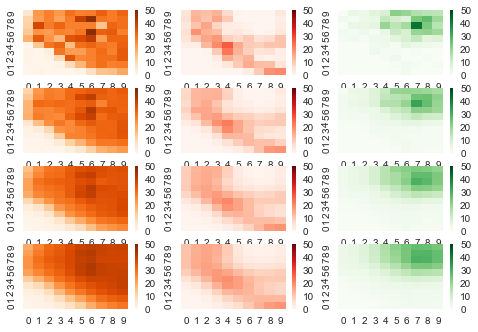

In [49]:
grid = testobject2.pd2np()
plotNum=4

time_step = int(testobject2.tot_time/plotNum)
grn = grid[0,:,:,:] 
red = grid[1,:,:,:]
both = grid[2,:,:,:]
# Plot heatmap for each time i*time_step
for i in range(plotNum):
    plt.subplot(plotNum,3,1+i*3)
    ax_b = sns.heatmap(both[1:-1,1:-1,i*time_step], vmin=0, vmax=50, 
                cmap="Oranges")
    ax_b.invert_yaxis()

    plt.subplot(plotNum,3,2+i*3)
    ax_r = sns.heatmap(red[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Reds")
    ax_r.invert_yaxis()

    plt.subplot(plotNum,3,3+i*3)
    ax_g = sns.heatmap(grn[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Greens")
    ax_g.invert_yaxis()

plt.figure()
grid = model.solver(k, testobject2)

time_step = int(testobject2.tot_time/plotNum)
grn = grid[0,:,:,:] 
red = grid[1,:,:,:]
both = grid[2,:,:,:]
plotNum=4
# Plot heatmap for each time i*time_step
for i in range(plotNum):
    plt.subplot(plotNum,3,1+i*3)
    ax_b = sns.heatmap(both[1:-1,1:-1,i*time_step], vmin=0, vmax=50, 
                cmap="Oranges")
    ax_b.invert_yaxis()

    plt.subplot(plotNum,3,2+i*3)
    ax_r = sns.heatmap(red[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Reds")
    ax_r.invert_yaxis()

    plt.subplot(plotNum,3,3+i*3)
    ax_g = sns.heatmap(grn[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Greens")
    ax_g.invert_yaxis()

# No diffusion

## 10 x 10 bins

In [22]:
imp.reload(model)

<module 'cellfate.model' from '/Users/lsh/Desktop/2016-17/PHYS 201/cellfate/cellfate/model.py'>

In [20]:
testobject = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 10)

In [44]:
x0 = np.array([0.1, 0.01, 0.01])

for i in range(10):
    test = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', (i+1)*2)
    m = model.solver_uncoupled(x0, test)
    y = test.pd2np()

    nonzero_args = np.nonzero(y)
    y = y[nonzero_args]
    m = m[nonzero_args]

    mzeros = len(np.where(m==0)[0])/len(m)
    print("For bin number %i, the fraction of remaining zeros in model is %.1f %%" %((i+1)*2, mzeros*100))

For bin number 2, the fraction of remaining zeros in model is 0.0 %
For bin number 4, the fraction of remaining zeros in model is 0.0 %
For bin number 6, the fraction of remaining zeros in model is 0.9 %
For bin number 8, the fraction of remaining zeros in model is 1.1 %
For bin number 10, the fraction of remaining zeros in model is 3.8 %
For bin number 12, the fraction of remaining zeros in model is 5.0 %
For bin number 14, the fraction of remaining zeros in model is 5.3 %
For bin number 16, the fraction of remaining zeros in model is 5.2 %
For bin number 18, the fraction of remaining zeros in model is 5.4 %
For bin number 20, the fraction of remaining zeros in model is 5.4 %


In [23]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.01, 0.01])

def residual(theta, data, mu_n, sigma_n):
    m = model.solver_uncoupled(theta, data)
    y = data.pd2np()

    nonzero_args = np.nonzero(y)
    y = y[nonzero_args]
    m = m[nonzero_args]
    
    nonzero_args = np.nonzero(m)
    y = y[nonzero_args]
    m = m[nonzero_args]
            
    return (np.log(y) - np.log(m) - mu_n)/sigma_n
    
res = op.leastsq(residual, x0, args=(testobject, -0.15, 0.1), full_output=1)

res[0]

array([ 0.02729355,  0.00557415,  0.01330024])

CPU times: user 8.73 s, sys: 897 ms, total: 9.62 s
Wall time: 2min 40s
Done


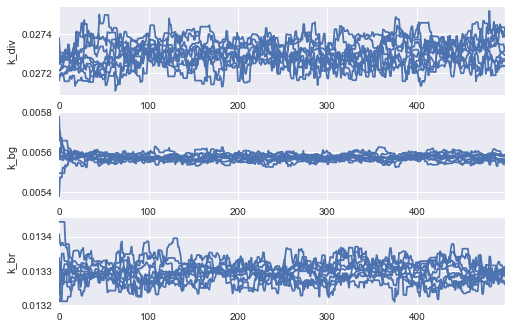

In [24]:
# We have 3 parameters. 
# We use 20 walkers and 500 steps, which turns out to be a sufficient number.
ndim = 3
nwalkers = 20
nsteps = 500
init_params = res[0]

# Starting positions in Gaussian ball
starting_positions = [init_params + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_posterior_uncoupled, 
                                args=(testobject, -0.15, 0.1), threads=4)

# Run the sampler.
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

# Let's plot 10 walkers from the samler chain to observe convergence.
fig, (ax_k_div, ax_k_bg, ax_k_br) = plt.subplots(3)
ax_k_div.set(ylabel='k_div')
ax_k_bg.set(ylabel='k_bg')
ax_k_br.set(ylabel='k_br')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_k_bg)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_k_br)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


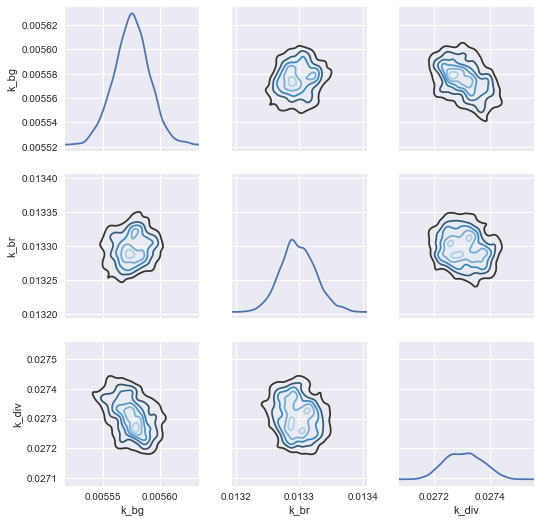

In [25]:
# Since V_b converges around 300, let's set burnin time as 300 steps.
samples = sampler.chain[:,300:,:]

# reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
traces = samples.reshape(-1, ndim).T

# Create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_bg': traces[1], 'k_br': traces[2]})

# Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
g = sns.PairGrid(parameter_samples)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);

In [28]:
k = [parameter_samples['k_div'].median(), parameter_samples['k_bg'].median(), parameter_samples['k_br'].median()]

print('k_div = %.5f' % (parameter_samples['k_div'].median()))
print('k_bg = %.5f' % (parameter_samples['k_bg'].median()))
print('k_br = %.5f' % (parameter_samples['k_br'].median()))

k_div = 0.02731
k_bg = 0.00558
k_br = 0.01330


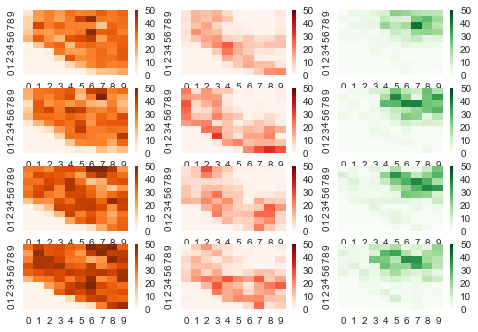

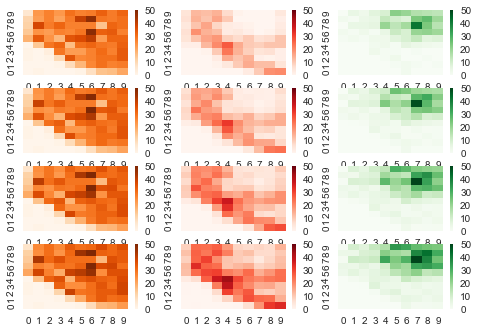

In [29]:
grid = testobject2.pd2np()
plotNum=4

time_step = int(testobject2.tot_time/plotNum)
grn = grid[0,:,:,:] 
red = grid[1,:,:,:]
both = grid[2,:,:,:]
# Plot heatmap for each time i*time_step
for i in range(plotNum):
    plt.subplot(plotNum,3,1+i*3)
    ax_b = sns.heatmap(both[1:-1,1:-1,i*time_step], vmin=0, vmax=50, 
                cmap="Oranges")
    ax_b.invert_yaxis()

    plt.subplot(plotNum,3,2+i*3)
    ax_r = sns.heatmap(red[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Reds")
    ax_r.invert_yaxis()

    plt.subplot(plotNum,3,3+i*3)
    ax_g = sns.heatmap(grn[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Greens")
    ax_g.invert_yaxis()

plt.figure()
grid = model.solver_uncoupled(k, testobject2)

time_step = int(testobject2.tot_time/plotNum)
grn = grid[0,:,:,:] 
red = grid[1,:,:,:]
both = grid[2,:,:,:]
plotNum=4
# Plot heatmap for each time i*time_step
for i in range(plotNum):
    plt.subplot(plotNum,3,1+i*3)
    ax_b = sns.heatmap(both[1:-1,1:-1,i*time_step], vmin=0, vmax=50, 
                cmap="Oranges")
    ax_b.invert_yaxis()

    plt.subplot(plotNum,3,2+i*3)
    ax_r = sns.heatmap(red[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Reds")
    ax_r.invert_yaxis()

    plt.subplot(plotNum,3,3+i*3)
    ax_g = sns.heatmap(grn[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Greens")
    ax_g.invert_yaxis()

# Total number of cells

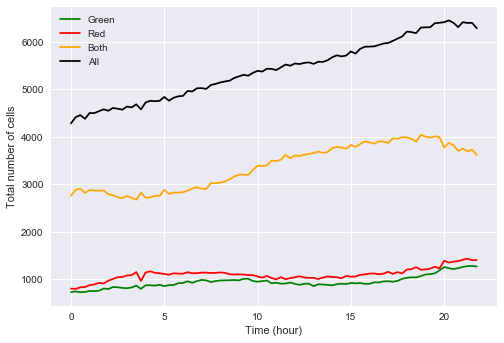

In [46]:
stepNum = int(testobject.tot_time)
M = np.zeros((4, stepNum))
for i in range(stepNum):
    M[0,i]=np.sum(testobject.pd2np()[0, :, :, i])
    M[1,i]=np.sum(testobject.pd2np()[1, :, :, i])
    M[2,i]=np.sum(testobject.pd2np()[2, :, :, i])
    M[3,i]=np.sum(testobject.pd2np()[:, :, :, i])
    
plt.plot(np.arange(stepNum)*.25, M[0], 'g', label='Green')
plt.plot(np.arange(stepNum)*.25, M[1], 'r', label='Red')
plt.plot(np.arange(stepNum)*.25, M[2], 'orange', label='Both')
plt.plot(np.arange(stepNum)*.25, M[3], 'k', label='All')
plt.xlabel('Time (hour)')
plt.ylabel('Total number of cells')
plt.legend()

## Length = 1.33, Laplacian

In [306]:
imp.reload(model)

<module 'cellfate.model' from '/Users/lsh/Desktop/2016-17/PHYS 201/cellfate/cellfate/model.py'>

CPU times: user 1h 47min 30s, sys: 52.1 s, total: 1h 48min 22s
Wall time: 3h 13min 5s
Done


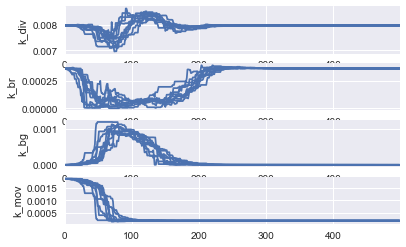

In [307]:
# We have 3 parameters. 
# We use 20 walkers and 500 steps, which turns out to be a sufficient number.
ndim = 4
nwalkers = 20
nsteps = 500
init_params = np.array([0.00797, 0.00036, 0.0000000069, 0.00184])

# Starting positions in Gaussian ball
starting_positions = [init_params + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_posterior2, 
                                args=(testobject, 0.1))

# Run the sampler.
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

# Let's plot 10 walkers from the samler chain to observe convergence.
fig, (ax_k_div, ax_k_br, ax_k_bg, ax_k_mov) = plt.subplots(4)
ax_k_div.set(ylabel='k_div')
ax_k_br.set(ylabel='k_br')
ax_k_bg.set(ylabel='k_bg')
ax_k_mov.set(ylabel='k_mov')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_k_br)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_k_bg)
    sns.tsplot(sampler.chain[i,:,3], ax=ax_k_mov)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


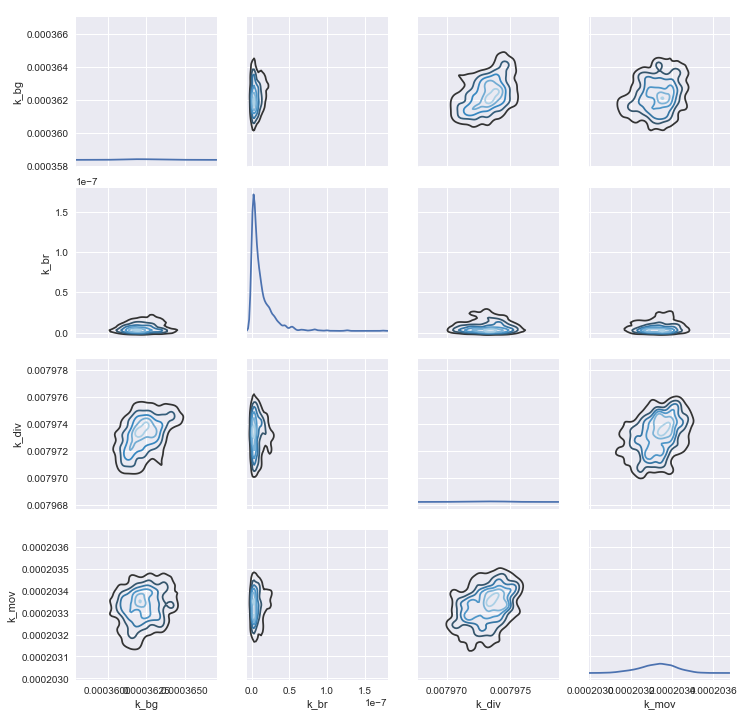

In [308]:
# Since V_b converges around 300, let's set burnin time as 300 steps.
samples = sampler.chain[:,300:,:]

# reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
traces = samples.reshape(-1, ndim).T

# Create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_bg': traces[1], 'k_br': traces[2], 'k_mov': traces[3]})

# Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
g = sns.PairGrid(parameter_samples)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);

In [309]:
k = [parameter_samples['k_div'].median(), parameter_samples['k_bg'].median(), parameter_samples['k_br'].median(),
    parameter_samples['k_mov'].median()]

print('k_div = %.5f' % (parameter_samples['k_div'].median()))
print('k_bg = %.5f' % (parameter_samples['k_bg'].median()))
print('k_br = %.10f' % (parameter_samples['k_br'].median()))
print('k_mov = %.5f' % (parameter_samples['k_mov'].median()))

k_div = 0.00797
k_bg = 0.00036
k_br = 0.0000000071
k_mov = 0.00020


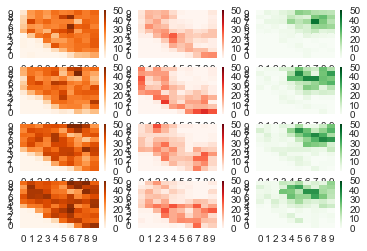

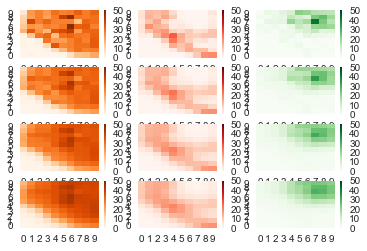

In [310]:
grid = testobject2.pd2np()

time_step = int(testobject2.tot_time/plotNum)
grn = grid[0,:,:,:] 
red = grid[1,:,:,:]
both = grid[2,:,:,:]
plotNum=4
# Plot heatmap for each time i*time_step
for i in range(plotNum):
    plt.subplot(plotNum,3,1+i*3)
    ax_b = sns.heatmap(both[1:-1,1:-1,i*time_step], vmin=0, vmax=50, 
                cmap="Oranges")
    ax_b.invert_yaxis()

    plt.subplot(plotNum,3,2+i*3)
    ax_r = sns.heatmap(red[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Reds")
    ax_r.invert_yaxis()

    plt.subplot(plotNum,3,3+i*3)
    ax_g = sns.heatmap(grn[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Greens")
    ax_g.invert_yaxis()

plt.figure()
grid = model.solver(k, testobject2)

time_step = int(testobject2.tot_time/plotNum)
grn = grid[0,:,:,:] 
red = grid[1,:,:,:]
both = grid[2,:,:,:]
plotNum=4
# Plot heatmap for each time i*time_step
for i in range(plotNum):
    plt.subplot(plotNum,3,1+i*3)
    ax_b = sns.heatmap(both[1:-1,1:-1,i*time_step], vmin=0, vmax=50, 
                cmap="Oranges")
    ax_b.invert_yaxis()

    plt.subplot(plotNum,3,2+i*3)
    ax_r = sns.heatmap(red[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Reds")
    ax_r.invert_yaxis()

    plt.subplot(plotNum,3,3+i*3)
    ax_g = sns.heatmap(grn[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Greens")
    ax_g.invert_yaxis()